# DAT565 Assignment 3 – Group 43

- Student 1 - Luca Modica - (5 hours)
- Student 2 - Hugo Alves Henriques E Silva - (5 hours)
- Student 3 - YenPo Lin - (5 hours)

September 8, 2023

## Introduction

The goal of this assignment is to use different clustering algorithms to group data, based on similarities measures, and find relevant patterns. We are about to perform an unsupervised learning task: starting from a dataset without labels, we will try to group the data points and extract insightful information from the results.

The dataset analyzed contains combinations of phi and psi angles (measured in degrees) observed in a large set of proteins. In the assignment we will often refer to a plot called *Ramachandran Plot*, which shows the statistical distribution of the combinations of the backbone dihedral angles ϕ and ψ. In this case, the goal will also be to use clustering algorithms to find similar sets to the one we can see in the Ramachandran Plot.

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# config inline plots
%matplotlib inline

# set seaborn style
sns.set_style('darkgrid')

## Data import and check

In [2]:
df = pd.read_csv('../datasets/protein-angle-dataset.csv')

In [3]:
df.head()

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520


In [4]:
df.describe()

,position,phi,psi
count,29369.000000,29369.000000,29369.000000
mean,182.917634,-82.362440,64.251961
std,130.180669,56.848421,91.119597
min,1.000000,-179.991175,-179.995255
25%,84.000000,-118.089883,-24.299401
50%,151.000000,-85.198070,110.903019
75%,257.000000,-63.287290,141.154709
max,772.000000,179.973856,179.986259


In [5]:
# Count the number of missing values in each column
null_count = df.isnull().sum()
print(null_count)

residue name    0
position        0
chain           0
phi             0
psi             0
dtype: int64


## Part 1: data visualization

To start having a first visualization of the phi and psi combination, we will show the data in a scatterplot.

In [6]:
def limit_axes_to_angles():
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)

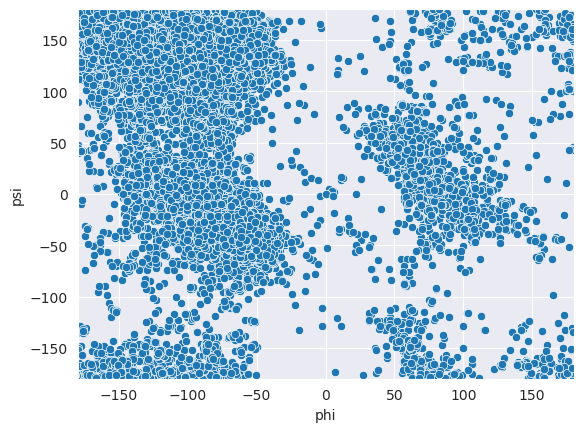

In [7]:
sns.scatterplot(data=df, x='phi', y='psi')
limit_axes_to_angles()

We can already see that data starts to assume patterns. Let's use a 2D histogram to also have clearer view of possible clusters and area with more data point density.

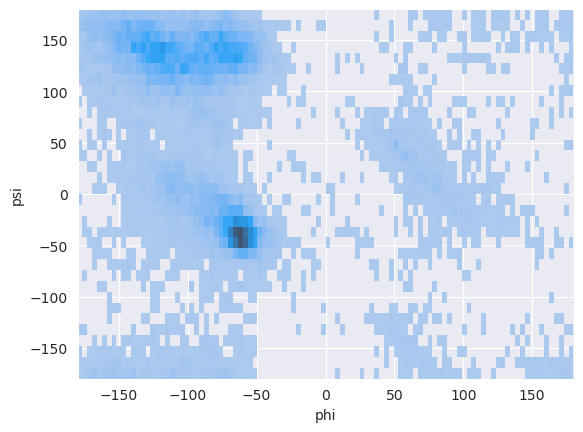

In [8]:
sns.histplot(df, x='phi', y='psi')
limit_axes_to_angles()

We can then take advantage of the kernel density estimation (KDE) to try to see better and delineate patterns in the data. The free parameters of kernel density estimation are the **kernel, which specifies the shape of the distribution placed at each point**, and the **kernel bandwidth, which controls the size of the kernel at each point**. This measure wil be useful especially for density-based cluster algorithms, like DBSCAN.

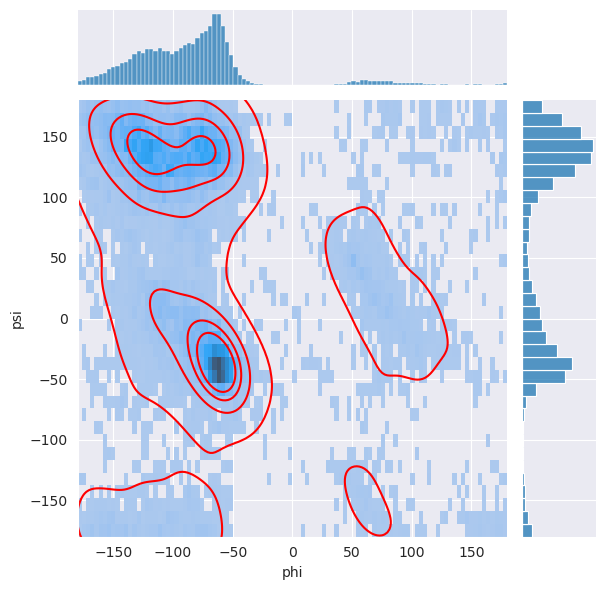

In [9]:
g = sns.jointplot(data=df, x="phi", y="psi", kind='hist')
g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=5)
limit_axes_to_angles()

### Dataset modification
The histogram above presents the distribution and density of the `phi` and `psi` angles.
The contour lines have been drawn in order to better interpret the plot. As we are working with angles, values at `-180º` are identical to the values at `180º`. Considering this fact, despite the area in the bottom left being classified as a unique cluster, it could possibly belong to the cluster above it. With the goal of getting a more precise visualization of the clusters, we can perform data shifts. This way, we can potentially make more accurate assumptions regarding the clusters. To examinate the hypothesis, angle shifting is going to be applied.

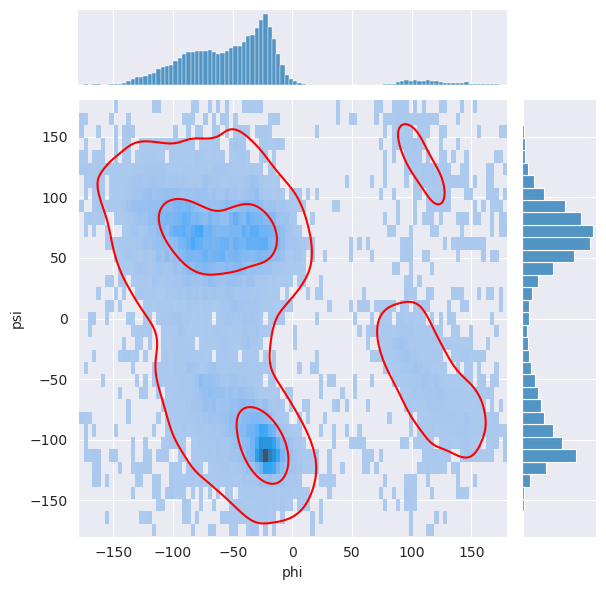

In [10]:
# angle shifting values
phi_angle_shift = 40
psi_angle_shift = -70

df_shifted = df.copy()
df_shifted['phi'] = ((df['phi'] + phi_angle_shift) + 180) % 360 - 180
df_shifted['psi'] = ((df['psi'] + psi_angle_shift) + 180) % 360 - 180

g = sns.jointplot(data=df_shifted, x='phi', y='psi', kind='hist')

g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=3)
limit_axes_to_angles()

After the shifting, the contour graph seems to be reasonable. The `Ramachandran plot` is a great evidence that the obtained graph makes sense. As the distribution and density are similar, the angle shifting is improving the analysis of the 2D histogram.
The Ramachandran Plot shows groups of physically allowed angle combinations (that avoid clashes) which correspond largely to the secondary structures observed in proteins:

- **alpha helices** (center left), 
- **beta sheets** (upper left), 
- and **turns** (right most).

<img src="images/ramachandran-plot.jpg" width="" align="" />

## Part 2: k-means clustering

### (a, b) Experiment with different values of k. Suggest an appropriate value of k for this task and motivate this choice. Do cluster found seem reasonable?

In experimenting different values of k, we want to find the most optimal and reasonable value.
For this task we will apply the elbow method using, as a measure of comparison between different values of k, the `wcss` (Within-Clusters Sum of Square).

In [11]:
wcss = [] 

for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, n_init='auto')
    kmeans.fit(df_shifted[['phi', 'psi']]) 
    wcss.append(kmeans.inertia_)

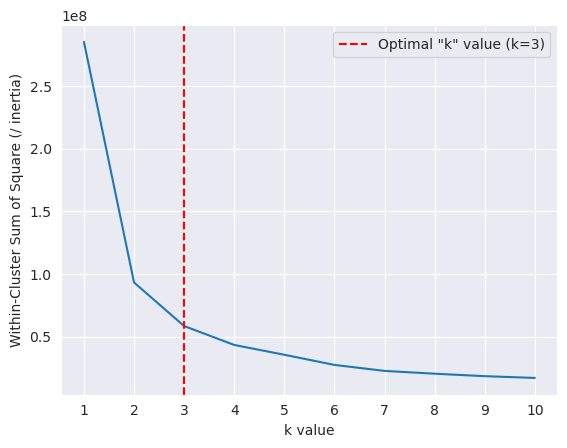

In [12]:
sns.lineplot(x=range(1, 11), y=wcss)
plt.xlabel('k value')
plt.ylabel('Within-Cluster Sum of Square (/ inertia)')
plt.xticks(np.arange(1, 11))
plt.axvline(x=3, color='red', linestyle='--', label='Optimal "k" value (k=3)')

plt.legend()
plt.show()

`k = 3` seems to be a reasonable choice: for the results obtained with the elbow method, since the value of the function for `k > 3` shows a more flat rate of change of the inertia. In other words, more clusters than the value chosen would not add much more useful information.

Now, we can plot the cluster with the optimal value of k.

In [13]:
def k_means_visualization(k, df, title):
    # k-means training
    kmeans = KMeans(n_clusters=3, n_init='auto')
    df_k_means = df.copy()
    df_k_means["kmeans_cluster"] = kmeans.fit_predict(df_k_means[['phi', 'psi']])

    # Visualize the K-Means clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_k_means, x='phi', y='psi', hue='kmeans_cluster', palette='viridis', s=50)
    plt.xlabel("Phi Angle (degrees)")
    plt.ylabel("Psi Angle (degrees)")
    plt.title(title)
    plt.grid(True)
    plt.legend(title='Cluster')

    # highlight clusters' centroids
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")

    plt.show()

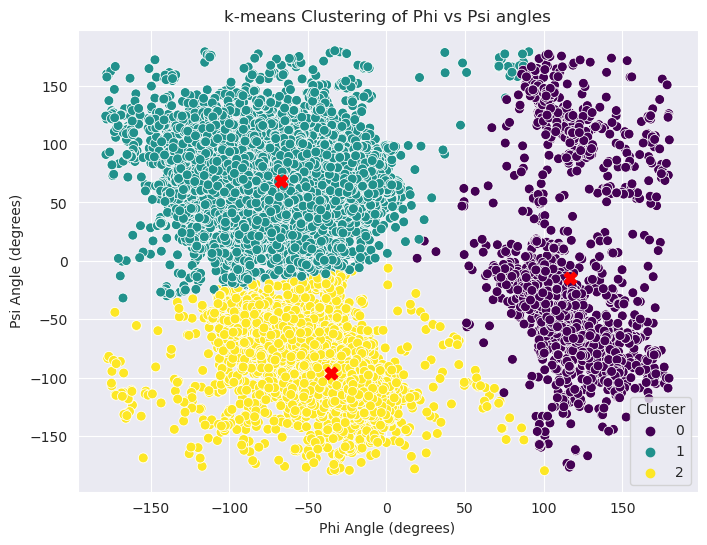

In [14]:
k_means_visualization(k=3, df=df_shifted, title='k-means Clustering of Phi vs Psi angles')

### Clustering validation

#### Random data removal

To verify that the k-means clusters are stable, we will remove a random sampling of datapoints and check if their shape is maintained. We will try:

1. removing 20% of the dataset;
2. removing 40% of the dataset.

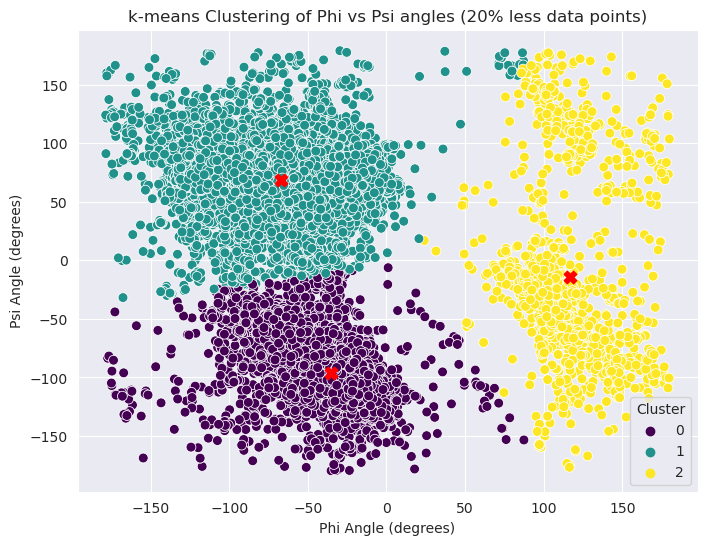

In [15]:
# removing 20% of the dat points randomly 
random_indices_20 = np.random.choice(len(df_shifted), int(0.2 * len(df_shifted)), replace=False)
df_validation_20 = df_shifted.drop(random_indices_20)

k_means_visualization(
    k=3, 
    df=df_validation_20, 
    title='k-means Clustering of Phi vs Psi angles (20% less data points)'
)

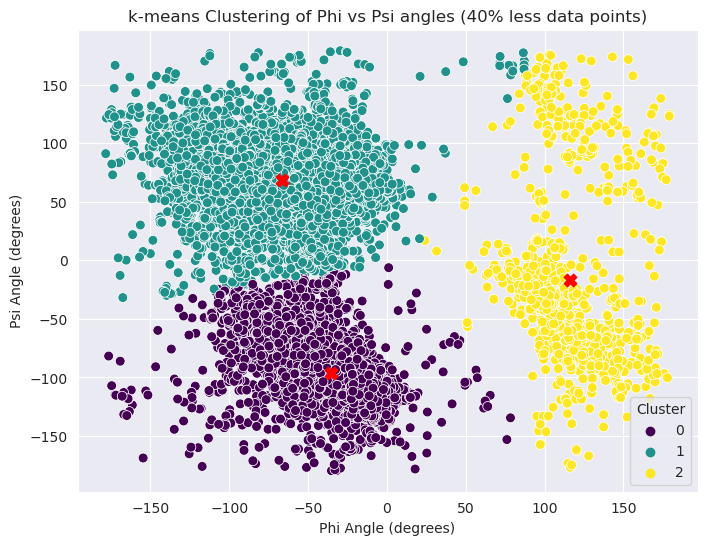

In [16]:
# removing 40% of the dat points randomly 
random_indices_40 = np.random.choice(len(df_shifted), int(0.4 * len(df_shifted)), replace=False)
df_validation_40 = df_shifted.drop(random_indices_40)

k_means_visualization(
    k=3, 
    df=df_validation_40, 
    title='k-means Clustering of Phi vs Psi angles (40% less data points)'
)

Our clustering using k-means is stable since even after dropping portions of the dataset, the clusters clearly maintain the same shapes.

In general, judging from the clusters obtained with the optimal k value, k-means seems to do a good job at separating the different datapoint groups. Although, these clusters, opposing to the ones that are shown in the 2D-histogram and KDE plot, consider the data points in areas with less density, which is not that insightful. This can be due to one of k-means limitations, which is finding clusters of equal diameter and size.

Furthermore, comparing the clusters found with the Ramachandran plot, the similarities between sets are not as strong. The reasoning relies on another k-means issue, which is not considerably taking into account the areas where datapoints are more dense.  

## Part 3: Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

### (a, b) Motivate the choice of the DBSCAN parameters values, comparing the clusters found with this algorithm with those found with k-means. Highlight the clusters found using DBSCAN and any outliers in a scatter plot.

DBSCAN relies on 2 hyperparameters:

- the minimum number of samples in the neighborhood for a point to be considered a core point (**min_samples**);
- the maximum distance between 2 samples belonging to the same neighborhood (**eps**, or *epsilon*).

The first task is to find optimal values for these 2 hyperparameters to obtain the optimal clusters. From the Ramachandran plot, and based on our dataset domain knowledge, we make 2 assumptions:

- we are expecting 3 clusters, corresponding to the most common groups of physically allowed angle combinations (*alpha helices*, *beta sheets* and *turns*);
- since in the 3 clusters that we can see in the Ramachandran plot there is a high density of points, we may expect a high number of points required in the neighborhood of a point to form a cluster.

Especially based on the second assumption, we started with a relatively high value minimum number of samples in the neighborhood for a point: `min_samples = 80`. This is also because choosing too low of a value for **min_samples** would end up in having too many noise points.

After selecting the `min_samples` value, we can use `NearestNeighbors` from Scikit-learn to calculate the average distance between each point and its `n_neighbors`.

In [17]:
neighbors = NearestNeighbors(n_neighbors=80)
neighbors_fit = neighbors.fit(df_shifted[['phi', 'psi']])
distances, indices = neighbors_fit.kneighbors(df_shifted[['phi', 'psi']])

# we compute the average distance between a point and its 80 neighbours, 
# and the mean with all of the distances computed. That value will be our
# first reasonable value of epsilon, since DBSCAN need a reasonable max distance measure
# of 2 point in a cluster to create reasonable clusters
distances.mean()

4.015686461907801

The ideal value for ε will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature. This point represents the optimization point where diminishing returns are no longer worth the additional cost. This concept of diminishing returns applies here because while increasing the number of clusters will always improve the fit of the model, it also increases the risk that overfitting will occur. In our case, we found as a first good epsilon value `eps=4`.

With our combination of values (`min_samples = 80`, `eps = 4`), we can experiment by creating the clusters with the DBSCAN algorithm.

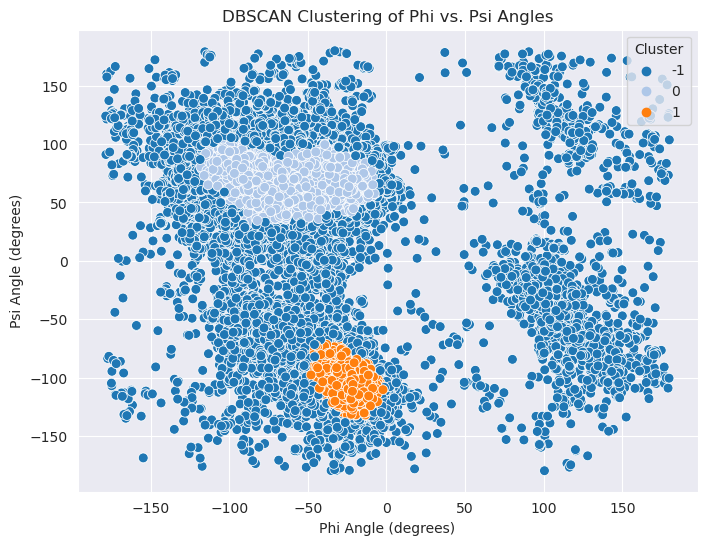

In [18]:
dbscan = DBSCAN(eps=4, min_samples=80)
df_shifted["dbscan_cluster"] = dbscan.fit_predict(df_shifted[['phi', 'psi']])

# Visualize the DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_shifted, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50)
plt.xlabel("Phi Angle (degrees)")
plt.ylabel("Psi Angle (degrees)")
plt.title("DBSCAN Clustering of Phi vs. Psi Angles")
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()


Regardless of the motivation, with the first combination we don't obtain the expected number of clusters, not matching the Ramachandran plot. To fine-tune our parameters, what we can do is a grid search with different combinations of **eps** and **min_samples**, including the values above. In this case, we will use the silhouette score to compare the value combinations.

In [19]:
def fine_tune_DBSCAN_hyperparams(df, eps_values, min_samples_values, min_expected_clusters=3):
    # Initialize variables to store the best parameters and their corresponding silhouette score
    best_params = None
    best_score = -1

    # Perform grid search manually using nested loops
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(df)

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

            # We must exclude the noise label (-1) before calculating the silhouette score.
            # also, from the Ramachandran plot we know how many clusters we want to have
            if n_clusters_ > 1 and -1 in labels and n_clusters_==min_expected_clusters:
                score = silhouette_score(df, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}

    # Print the results
    if best_params is not None:
        print("Best parameters: ", best_params)
        print("Best Silhouette Score: ", best_score)
    else:
        print("No valid parameter combination found")

In [20]:
# Define the parameter grid to search
eps_values = [4, 7, 10, 20]
min_samples_values = [80, 100]
fine_tune_DBSCAN_hyperparams(df_shifted[['phi', 'psi']], eps_values, min_samples_values)

Best parameters:  {'eps': 10, 'min_samples': 80}
Best Silhouette Score:  0.6079813031387805


The chosen parameters are:

- **eps**: 10,
- **min_samples**: 80.

Now we will plot all the datapoints on a scatter plot and represent them in different colors according to which cluster they belong to and taking into account their representation on the `ramachandran plot`:

- **class -1**: `outliers`
- **class 0**: `Beta`
- **class 1**: `Alpha`
- **class 2**: `Turn`


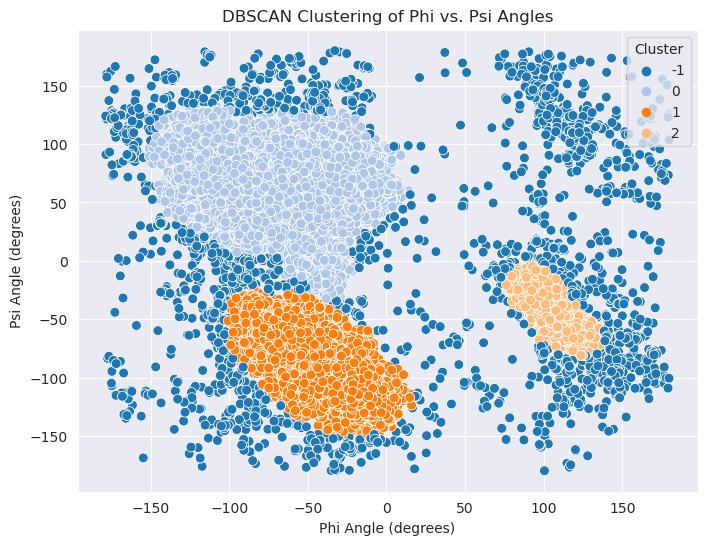

In [21]:
# Implement DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=80)  # Example parameters, adjust as needed
df_shifted["dbscan_cluster"] = dbscan.fit_predict(df_shifted[['phi', 'psi']])

# Visualize the DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_shifted, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50)
plt.xlabel("Phi Angle (degrees)")
plt.ylabel("Psi Angle (degrees)")
plt.title("DBSCAN Clustering of Phi vs. Psi Angles")
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

Comparing to the clusters found in k-means, DBSCAN seems to do a better job in shaping the clusters similarly to the Ramachandran plot, also detecting outliers. The outliers, in this context, are all of the combinations of angles which can be:

- not part of the 3 main sets of the Ramachandran plot;
- a phisycally impossible angle combination.

K-Means does not take density into account, therefore it will not identify outliers.
On the other hand, DBSCAN does not produce stable clusters. Small changes in the hyperparameters produce quite different results, whereas k-Means clusters are more stable in that way. DBSCAN is more sensible to changes in hyperparameters.
All in all, DBSCAN produces more similar results to the Ramachandran Plot when given the right hyperparameters.

### (c) How many outliers are found? Plot a bar chart to show how often each of the amino acid residue types are outliers.

First we need to find out which data points are considered as `outliers`

In [22]:
# Determine the number of outliers
outliers = df_shifted[df_shifted["dbscan_cluster"] == -1]
num_outliers = len(outliers)
print(f"Number of outliers: {num_outliers}")

Number of outliers: 2340


There are 2340 datapoints that are considered as outliers since these points are not clustered. In other words, these points do not belong to any of the cluster when applying DBSCAN method. 

To further analyze the outliers, we will group various of their classes based on the residue type and present the distribution on a bar chart.

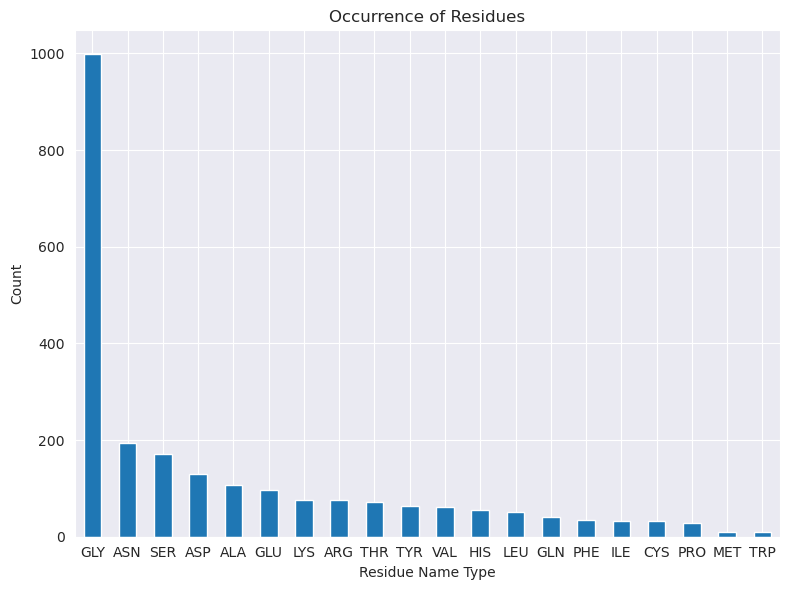

In [23]:
residue_counts=outliers['residue name'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
residue_counts.plot(kind='bar', ax=ax)
ax.set_title('Occurrence of Residues')
ax.set_ylabel('Count')
ax.set_xlabel('Residue Name Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Part 4: DBSCAN to cluster data that has residue type PRO

For this question, we will filter out the data points that have residue type PRO and use DBSCAN to cluster them. We will firstly use the same hyperparameters that were used in the previous question.

/tmp/ipykernel_3796/2418606545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shifted_PRO["dbscan_cluster"] = dbscan.fit_predict(df_shifted_PRO[['phi', 'psi']])


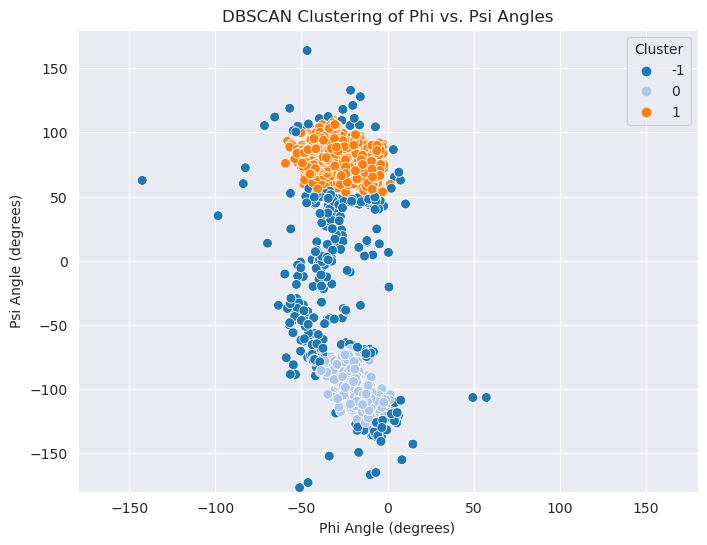

Number of outliers: 349


In [24]:
# filter by by residue type PRO
df_shifted_PRO = df_shifted[df_shifted['residue name'] == 'PRO']

# Implement DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=80)
df_shifted_PRO["dbscan_cluster"] = dbscan.fit_predict(df_shifted_PRO[['phi', 'psi']])

# Visualize the DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_shifted_PRO, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50)
plt.xlabel("Phi Angle (degrees)")
plt.ylabel("Psi Angle (degrees)")
plt.title("DBSCAN Clustering of Phi vs. Psi Angles")
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
limit_axes_to_angles()
plt.show()

# Determine the number of outliers
outliers = df_shifted_PRO[df_shifted_PRO["dbscan_cluster"] == -1]
num_outliers = len(outliers)
print(f"Number of outliers: {num_outliers}")

As DBSCAN produces unstable clusters and as we have significantly reduced the number of data points, the same hyperparameters that we used in the previous question could not fit as well.
This way, we will have to fine-tune the hyperparameters in order to obtain accurate assumptions.
Furthermore, based on the domain knowledge related to Remachandran plot for the residue type PRO, in this case we expect 2 clusters as a consistent number of clusters from DBSCAN.

<img src="images/ramachandran-plot-PRO.jpg" width="" align="" />

In [25]:
fine_tune_DBSCAN_hyperparams(df_shifted_PRO[['phi', 'psi']], [4, 7, 10], [50, 80], min_expected_clusters=2)

Best parameters:  {'eps': 10, 'min_samples': 50}
Best Silhouette Score:  0.6353147379287376


/tmp/ipykernel_3796/731281540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shifted_PRO["dbscan_cluster"] = dbscan.fit_predict(df_shifted_PRO[['phi', 'psi']])


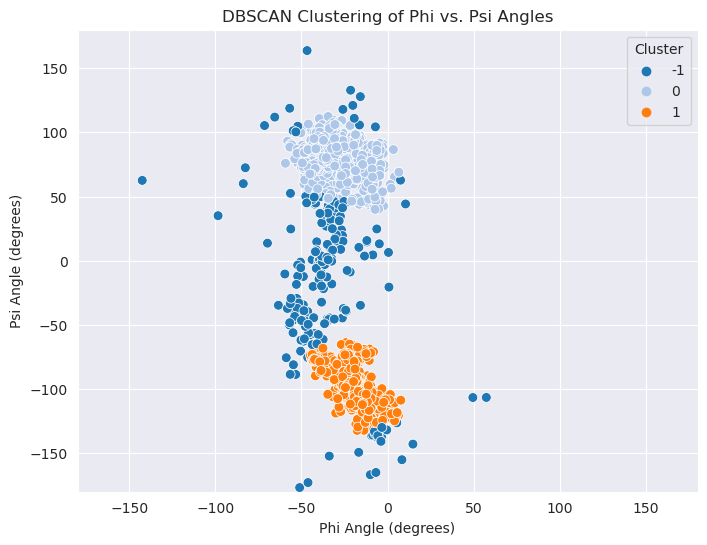

Number of outliers: 215


In [26]:
# Implement DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=50)
df_shifted_PRO["dbscan_cluster"] = dbscan.fit_predict(df_shifted_PRO[['phi', 'psi']])

# Visualize the DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_shifted_PRO, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50)
plt.xlabel("Phi Angle (degrees)")
plt.ylabel("Psi Angle (degrees)")
plt.title("DBSCAN Clustering of Phi vs. Psi Angles")
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
limit_axes_to_angles()
plt.show()

# Determine the number of outliers
outliers = df_shifted_PRO[df_shifted_PRO["dbscan_cluster"] == -1]
num_outliers = len(outliers)
print(f"Number of outliers: {num_outliers}")

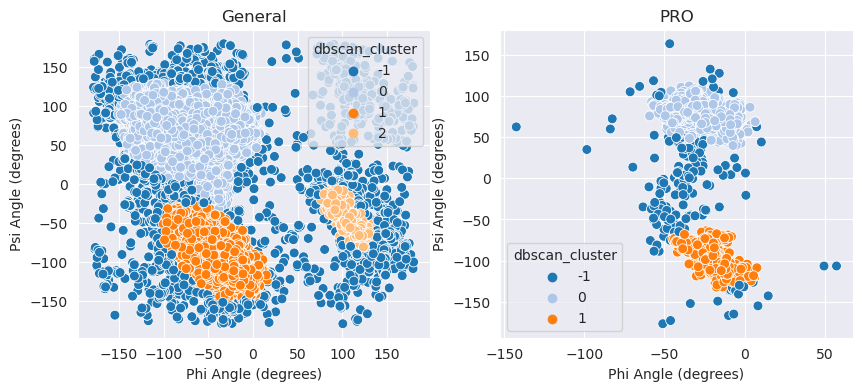

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df_shifted, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50,ax=ax1)
ax1.set_xlabel("Phi Angle (degrees)")
ax1.set_ylabel("Psi Angle (degrees)")
ax1.set_title("General")

sns.scatterplot(data=df_shifted_PRO, x='phi', y='psi', hue='dbscan_cluster', palette='tab20', s=50,ax=ax2)
ax2.set_xlabel("Phi Angle (degrees)")
ax2.set_ylabel("Psi Angle (degrees)")
ax2.set_title("PRO")
plt.show()

We can notice that the clusters refering to the residue type PRO tend to have a similar distribution for the alpha helices and the beta sheet sets (we know from the domain knowledge instead that PRO type has no turn angle combinations). A reason for this similarity in distribution can be the presence of few outliers related to the PRO residue type, in the general case. So, we can expect the same behavior.